# Variational Autoencoders

Implementation of a variational autoencoder.

In [1]:
import numpy as np
from collections import namedtuple

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

import show_graph # This allows to show the graph

mnist = read_data_sets('MNIST_data')
INPUT_DIM = 28**2

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def lazy_property(function):
    """Decorator that stores the propery after its first call
    """
    attr_name = '_cached_' + function.__name__

    @property
    def _lazy_property(self):
        if not hasattr(self, attr_name):
            setattr(self, attr_name, function(self))
        return getattr(self, attr_name)
    
    _lazy_property.__doc__ = function.__doc__
    return _lazy_property


def with_scope(function):
    """Decorator that covers the function in a tf.Scope
    """
    
    tensorname = function.__name__
    
    def function_with_scope(self):
        with tf.variable_scope(tensorname):
            tensor = function(self)
        return tensor
    
    function_with_scope.__name__ = function.__name__
    function_with_scope.__doc__ = function.__doc__
    return function_with_scope

In [3]:
def binominal_cross_entropy(x, y):
    y = tf.clip_by_value(y, 1e-8, 1 - 1e-8)
    return x * tf.log(y) + (1 - x) * tf.log(1 - y)

# The model

In [4]:
class Encoder:
    """Gaussian encoder via an CNN
    
    Args:
        output_dim (int): the dimension of the latent vector
    """
    def __init__(self, output_dim):
        self.output_dim = output_dim

    def __call__(self, inputs):
        """Builds the encoder

        Args:
            inputs (tf.Tensor [?, 28**2]): the input images
        Returns:
            sample, (mean, std_dev): all tf.Tensor[?, output_dim]
                sample is a normal distrubuted random variable 
                with the `mean` and standart deviation `std_dev`           
        """
        layer = tf.identity(inputs, name="inputs")
        with tf.variable_scope("hidden"):
            layer = tf.reshape(layer, [-1, 28, 28, 1])
            layer = tf.layers.conv2d(layer, 4, 5, padding='same')
            layer = tf.layers.max_pooling2d(layer, 2, 2, padding='same')
            layer = tf.nn.relu(layer)
            layer = tf.layers.conv2d(layer, 8, 5, padding='same')
            layer = tf.layers.max_pooling2d(layer, 2, 2, padding='same')
            layer = tf.nn.relu(layer)
            layer = tf.reshape(layer, [-1, int(np.prod(layer.shape[1:]))])
            layer = tf.layers.dense(layer, 32, activation=tf.nn.softplus)
            keep_prob = tf.placeholder_with_default(1.0, [])
            layer = tf.nn.dropout(layer, keep_prob)
            hidden_output = layer


        with tf.variable_scope("variational_param"):
            mean = tf.layers.dense(hidden_output, self.output_dim, name="mean",
                                   kernel_initializer=tf.contrib.layers.xavier_initializer())
            std_dev = tf.layers.dense(hidden_output, self.output_dim, 
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                       activation=tf.nn.softplus,
                                       name="std_dev")

        with tf.variable_scope("sample"):    
            sample = mean + tf.sqrt(std_dev) * tf.random_normal(tf.shape(std_dev))
            sample = tf.identity(sample, name="output")
        return sample, (mean, std_dev)
    

def decoder(inputs):
    """Bernoulli decoder via an (transposed) CNN
    
    Args:
        inputs (tf.Tensor [?, ?]): the inputs
    
    Returns
        sample, (mean, std_dev): all tf.Tensor[?, 28**2]
            sample is a bernoulli distrubuted random variable 
            and its mean id `mean`
    """
    layer = tf.identity(inputs, name="inputs")
    with tf.variable_scope("hidden"):
        layer = tf.layers.dense(layer, 32, tf.nn.softplus)
        layer = tf.layers.dense(layer, 7 * 7 * 8, tf.nn.softplus)
        layer = tf.reshape(layer, [-1, 7, 7, 8])
        layer = tf.layers.conv2d_transpose(layer, 4, 5, 2, padding='SAME')
        layer = tf.nn.relu(layer)
        layer = tf.layers.conv2d_transpose(layer, 1, 5, 2, padding='SAME')
        layer = tf.nn.sigmoid(layer)
        layer = tf.reshape(layer, [-1, 28 * 28])
        hidden_output = layer

    with tf.variable_scope("variational_param"):
        mean = tf.identity(hidden_output, name="mean")
    with tf.variable_scope("sample"):    
        sample = mean * tf.random_uniform(tf.shape(mean), 0, 1, dtype=tf.float32)
        sample = tf.identity(sample, name="output")
    return sample, (mean,)

In [5]:
class VariationalAutoEncoder:
    BATCH_SIZE = None
    
    def __init__(self, encoder, decoder):
        

        self.inputs = tf.placeholder(tf.float32, shape=(self.BATCH_SIZE, INPUT_DIM), name="inputs")
    
        #inference network
        with tf.variable_scope("encoder"):
            self.latent_vector, (self.mean, self.std_dev) = encoder(self.inputs)
            
        # generative network
        with tf.variable_scope("decoder"):
            _, (self.output,) = decoder(self.latent_vector)
        
        self.train_op
        self.initializer
        
    @lazy_property
    @with_scope    
    def initializer(self):
        return [tf.global_variables_initializer(), tf.local_variables_initializer()]

    @lazy_property
    @with_scope    
    def _reconstruction_loss(self): 
        """The loss of the reconstruction
        
        This loss is the negative log likelihood that the original data is regonstructed
        
        """
        return - tf.reduce_sum(binominal_cross_entropy(self.inputs, self.output), axis=1)
    
    @lazy_property
    @with_scope
    def _latent_loss(self):
        """The regularizer favoring normal distributed latent vectors by the generator
        
        This is the Kullback Leibler divergence D(q(z|x) || N(0,1)) betweent the 
        distrtibution q(z|x) for the latent vector z given the input x. 
        """
        return - 1/2 * tf.reduce_sum(2 * tf.log(1e-8 + self.std_dev) 
                                    - tf.square(self.mean) 
                                    - tf.square(self.std_dev), 
                                    axis=1)
                                       
    @lazy_property
    @with_scope
    def loss(self):
        """The total loss given by -ELBO (evidence lower bound)
        """
        return tf.reduce_mean(self._reconstruction_loss + self._latent_loss)  

    @lazy_property
    @with_scope
    def train_op(self):
        """Training operation"""
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        return optimizer.minimize(self.loss)
    
    @lazy_property
    @with_scope
    def learning_rate(self):
        """ learning rate of the train_op"""
        return tf.placeholder_with_default(0.001, [])

In [8]:
tf.reset_default_graph()
model = VariationalAutoEncoder(Encoder(10), decoder)

sess = tf.Session()
sess.run(model.initializer)

show_graph.show()

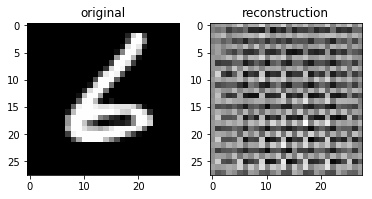

In [7]:
def show_example(image, model, sess):
    reconstructed_image, = sess.run(model.output, feed_dict={model.inputs: [image]})
    plt.subplot(121)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title("original")

    plt.subplot(122)
    plt.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    plt.title("reconstruction")

show_example(mnist.train.next_batch(1)[0][0], model, sess)

In [8]:
def train(model,  batch_size=128, n_train_steps=10000, evaluate_every_n_step=100):
    costs = []
    for step in range(n_train_steps):
        batch, _ = mnist.train.next_batch(batch_size)
        cost, _ = sess.run([model.loss, model.train_op], 
                           feed_dict={model.inputs: batch,
                                      model.learning_rate: 0.01})
        costs.append(cost)
        if step % evaluate_every_n_step == 0:
            print(np.mean(costs))
            costs = []

In [9]:
sess.run(model.initializer)

[None, None]

In [10]:
# This may take some time
train(model, 25, 5000, 200)

551.181
213.13
181.519
166.166
160.084
154.555
153.31
151.102
149.349
149.204
147.093
146.596
145.231
144.988
144.929
144.114
144.452
144.029
144.175
143.191
143.183
141.6
141.579
140.589
140.497


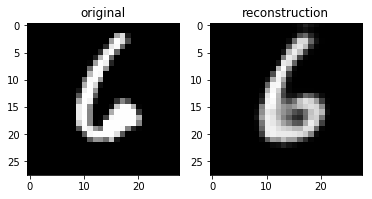

In [11]:
show_example(mnist.train.next_batch(1)[0][0], model, sess)

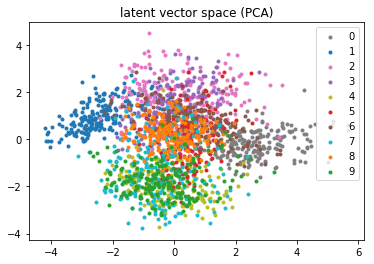

In [12]:
def show_latent_vector_space(model, sess):
    images, digits = mnist.test.next_batch(2000)
    latent_vector_mean = sess.run(model.mean, feed_dict={model.inputs: images})

    if len(latent_vector_mean[0]) > 2:
        # perform PCA
        from sklearn.decomposition import PCA
        pca = PCA(2)
        vectors = pca.fit(latent_vector_mean).transform(latent_vector_mean)
    else:
        # nothing to do
        vectors = latent_vector_mean

    colors =  {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
               'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
               'tab:olive', 'tab:cyan'} 
    for color, digit in zip(colors, range(10)):
        plt.scatter(vectors[digits == digit, 0], vectors[digits == digit, 1],
                    c=color, label=str(digit), marker='.')
    plt.legend()
    plt.title('latent vector space (PCA)')

    plt.show()
    
show_latent_vector_space(model, sess)

# The same for a simpler model, namely a fully-connected multi-layer perceptron. 
Here with two-dimensional latent-vector space

In [13]:
def encoder_simple(inputs, hidden_layer_sizes=[100, 10], output_dim=2):
    """ Gaussian encoder to 2-dimensional latent vector by fully connected MLP
    """
    with tf.variable_scope("hidden"):
        hidden_output = inputs
        for size in hidden_layer_sizes:
            hidden_output = tf.layers.dense(
                   hidden_output, size, tf.nn.softplus,
                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                   name=f'hidden_{size}')

    with tf.variable_scope("variational_param"):
        mean = tf.layers.dense(hidden_output, output_dim, name="mean",
                               kernel_initializer=tf.contrib.layers.xavier_initializer())
        std_dev = tf.layers.dense(hidden_output, output_dim, 
                                   kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                   activation=tf.nn.softplus,
                                   name="std_dev")
        
    with tf.variable_scope("sample"):    
        sample = mean + tf.sqrt(std_dev) * tf.random_normal(tf.shape(std_dev))
        sample = tf.identity(sample, name="output")
    return sample, (mean, std_dev)


def decoder_simple(inputs, hidden_layer_sizes=[10, 100], output_dim=INPUT_DIM):
    """ Bernoulli decoder to 28**2-dimensional vector by fully connected MLP
    """
    inputs = tf.identity(inputs, name="inputs")
    with tf.variable_scope("hidden"):
        hidden_output = inputs
        for size in hidden_layer_sizes:
            hidden_output = tf.layers.dense(hidden_output, size, tf.nn.softplus,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name=f'hidden_{size}')
    with tf.variable_scope("variational_param"):
        mean = tf.layers.dense(hidden_output, output_dim, tf.nn.sigmoid)
        mean = tf.identity(mean, name="mean")
    with tf.variable_scope("sample"):    
        sample = mean * tf.random_uniform(tf.shape(mean), 0, 1, dtype=tf.float32)
        sample = tf.identity(sample, name="output")
    return sample, (mean,)

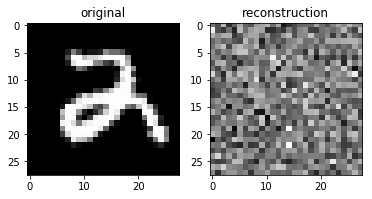

In [14]:
tf.reset_default_graph()
model = VariationalAutoEncoder(encoder_simple, decoder_simple)

sess = tf.Session()
sess.run(model.initializer)

show_example(mnist.train.next_batch(1)[0][0], model, sess)

In [15]:
train(model, 64, 8000, 500)

548.353
189.646
170.505
166.891
164.226
162.922
161.133
160.75
159.598
159.366
158.888
158.449
157.998
157.783
157.666
156.878


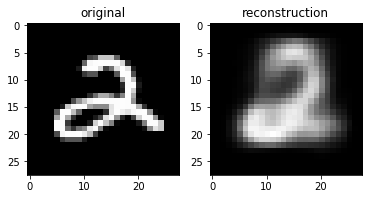

In [16]:
show_example(mnist.train.next_batch(1)[0][0], model, sess)

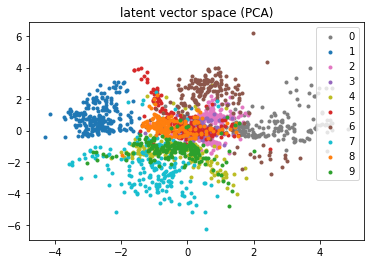

In [17]:
show_latent_vector_space(model, sess)